In [14]:
import pandas as pd
import numpy as np
from preprocess.config.config import Conf
from preprocess.clinical import ClinicalData
from preprocess.mutation import MutationData

from preprocess.config.patient_mappings import PatientMappings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier

In [15]:
clinical_data = ClinicalData(Conf.datasets['Clinical'])
clinical_data.preprocess_data()

In [16]:
patient_mappings = PatientMappings(clinical_data()['patient_id'])

In [17]:
mutation_data = MutationData(Conf.datasets['Mutation'])
mutation_data.add_stage_data(clinical_data)
mutation_data.clean_data()

In [18]:
X = mutation_data().drop(['patient_id', 'pathologic_stage'], axis=1)
Y = mutation_data()['pathologic_stage'] - 1

In [19]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42, k_neighbors=4)
# X_resampled, Y_resampled = smote.fit_resample(X, Y)

X_resampled, Y_resampled = X, Y
# X.shape, Y.shape, X_resampled.shape, Y_resampled.shape

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=999)

Y_test.value_counts(), Y_train.value_counts()

(pathologic_stage
 1    22
 0     3
 Name: count, dtype: int64,
 pathologic_stage
 1    86
 0    13
 Name: count, dtype: int64)

In [21]:
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(Y.unique()),
    eval_metric="mlogloss"
)

model.fit(
    X_train, 
    Y_train,
    eval_set=[(X_test, Y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [22]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

accuracy = accuracy_score(Y_test, Y_pred_classes) * 100.0
classification_rep = classification_report(Y_test, Y_pred_classes)

print(f"Test accuracy: {accuracy:.2f}%")
print("\n\nClassification Report:\n")
print(classification_rep)

Test accuracy: 88.00%


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.88      1.00      0.94        22

    accuracy                           0.88        25
   macro avg       0.44      0.50      0.47        25
weighted avg       0.77      0.88      0.82        25



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [23]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

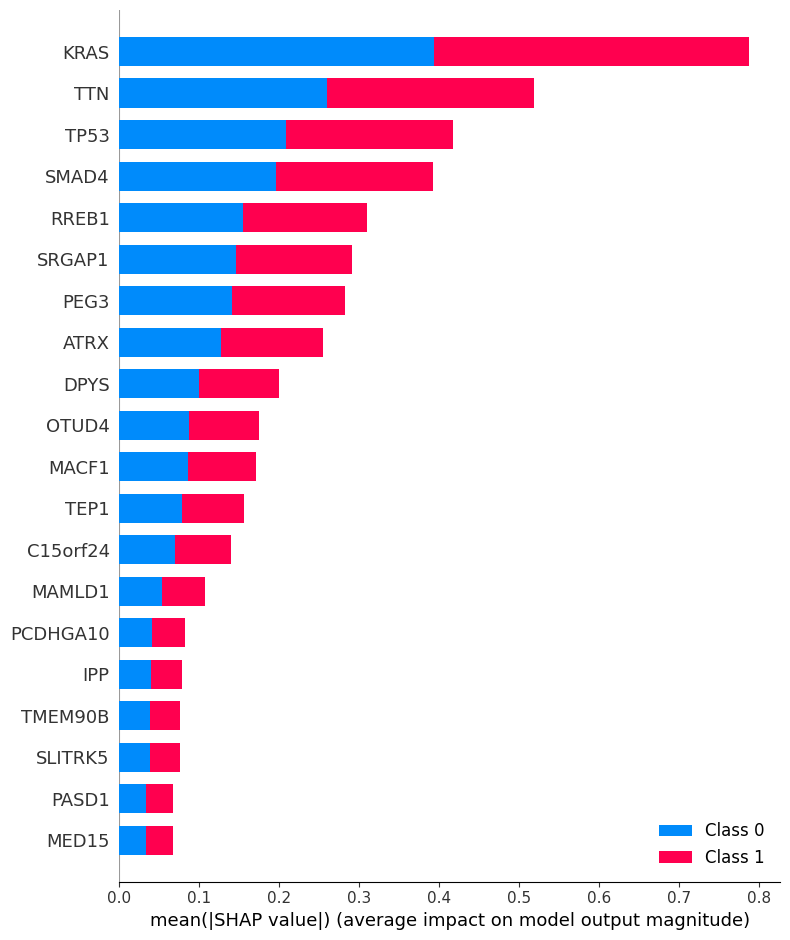

In [24]:
shap.summary_plot(shap_values, X)

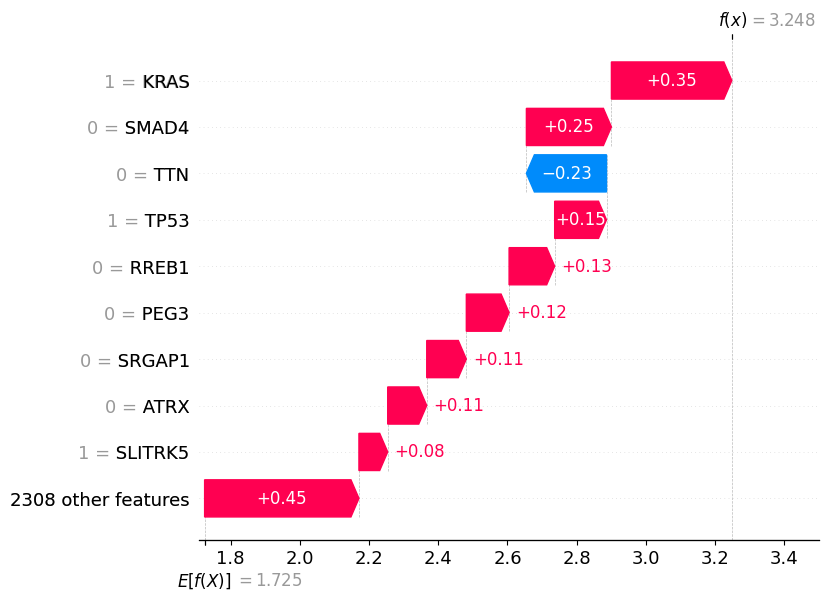

In [25]:
instance_index = 10
shap_value = shap_values[1][instance_index]
instance_data = X.iloc[instance_index]

shap.waterfall_plot(shap.Explanation(values=shap_value,
                                     base_values=explainer.expected_value[1],
                                     data=instance_data,
                                     feature_names=X_test.columns))

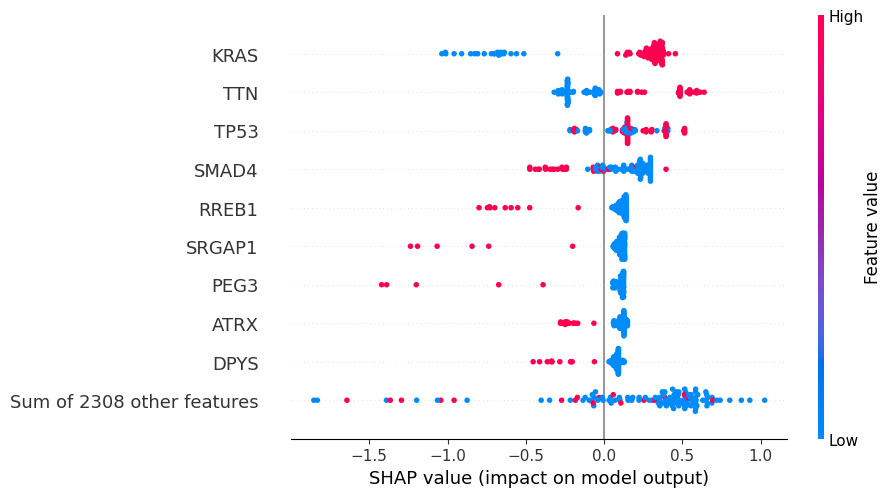

In [26]:
stage = 1

shap.plots.beeswarm(shap.Explanation(values=shap_values[stage],
                                     base_values=explainer.expected_value[stage],
                                     data=X,
                                     feature_names=X.columns))